In [2]:
import sys
import os
import glob
import json
import pandas as pd
%matplotlib inline
import matplotlib
import numpy as np

In [3]:
def find_files(path):
    return glob.glob(path)

In [4]:
def read_json(filename):
    with open(filename) as json_file:
        data = json.load(json_file)
    return data

### Az adathalmaz letöltése

In [5]:
from torchtext.utils import download_from_url, extract_archive

dataset_tar = download_from_url('https://drive.google.com/uc?id=1k7GfVRqrHFK00ABkit0oGQo62fCakMSZ', root='.data/')
extracted_files = extract_archive(dataset_tar)

## Adatok olvasása
Adatok beolvasása JSON fájlként, majd egy nagy pandas-os DataFrame-mé alakítása.

In [6]:
json_data = []

for file in find_files('.data/gyakori_*'):
    print("Reading file:", file)
    json_data.append(read_json(file))
    
data_frame = pd.DataFrame()

for data in json_data:
    frames  = [data_frame, pd.DataFrame(data)]
    data_frame = pd.concat(frames).reset_index(drop=True)

Reading file: .data/gyakori_szamitastechnika
Reading file: .data/gyakori_egeszseg
Reading file: .data/gyakori_egeszseg_20000
Reading file: .data/gyakori_allatok_14000
Reading file: .data/gyakori_szorakozas_30000


## Bepillantás a kérdésekbe
Csak hogy tudjuk pontosan mivel is állunk szemben. Minden kérdéshez tartozik a kérdés rövid, illetve hosszú verziója, egy válasz, amit a felhasználók a leghasznosabbnak találtak. Ezeken kívül kategóriák és kulcsszavak is vannak a kérdéshez.

In [7]:
data_frame.head(2)

,valasz,kategoriak,hosszu_kerdes,rovid_kerdes,keywords
0,Várak régen is voltak. Ha mindhárom tornyot le...,"[Számítástechnika, Internet]",Miért lett ilyen sz@r a honfoglaló? Régen tök ...,Miért lett ilyen sz@r a honfoglaló?,"[Honfoglaló, vár]"
1,"Ahogy írták, az stdio az a C-s függvénykönyvtá...","[Számítástechnika, Programozás]",C++-ban melyiket érdemesebb használni? Stdio v...,C++-ban melyiket érdemesebb használni? Stdio v...,"[C++, iostream, konzol, Windows, Visual Studio]"


### Túl kicsi kategóriák szűrése
Ha egy kategóriához túl kevés kérdés tartozik, akkor nem érdemes a továbbiakban foglalkozni vele. A túl kicsi kategóriák szűrése következik.

In [8]:
target_names = data_frame['kategoriak'].apply(lambda x: x[0]).unique().tolist()

minimum_questions_for_each_category = 3000

for target in target_names:
    target_size = data_frame[data_frame['kategoriak'].apply(lambda x : x[0]) == target].shape[0]
    if target_size < minimum_questions_for_each_category:
        data_frame = data_frame[data_frame['kategoriak'].apply(lambda x : x[0]) != target]


### Túl rövid kérdések szűrése
A túl rövid kérdések nem túl hasznosak. Az adathalmazban előfordul pár 2 szóból álló HOSSZÚ kérdés. Vegyük például a következő kérdéseket: `Militaryra appalosa?`, `Ivabradine vélemények?`. Ezek a kérdések nem meghatározóak a témájukra nézve.

In [9]:
minimum_words_per_question = 5
data_frame = data_frame[data_frame['hosszu_kerdes'].apply(lambda x: len(x.split())) >= minimum_words_per_question]

## "Főkategóriák" kigyűjtése
Az egyes főkategóriák neveinek kigyűjtése, majd az egyes nevekhez egy azonosító szám rendelése.

In [10]:
def get_target_names(idx, data_frame):
    target_names = data_frame['kategoriak'].apply(lambda x: x[idx]).unique().tolist()
    target_dict =  {value: key for key, value in enumerate(target_names)}
    
    return target_names, target_dict, len(target_names)

In [11]:
target_names, target_dict, num_of_categories = get_target_names(0, data_frame)

print(target_names)
print(target_dict)
print("Kategóriák száma: ", num_of_categories)

['Számítástechnika', 'Egészség', 'Állatok', 'Szórakozás']
{'Számítástechnika': 0, 'Egészség': 1, 'Állatok': 2, 'Szórakozás': 3}
Kategóriák száma:  4


## Tanító adathalmaz előállítása
A tanító adathalmazban minden egyes főkategóriából ugyanannyi kérdésnek kell szerepelnie (így fair). Itt pontosan ez történik `questions_from_each_category` darab kérdés kerül a tanító adathalmazba minden kategóriából, majd az eredményül kapott tömb véletlenszerűen összekeveredik.

#### Shuffle together
A shuffle_together függvény két listát véletlenszerűen kever össze, úgy, hogy az a keverés előtt az egyes listákban azonos indexen szereplő értékek a keverés után is azonos indexen lesznek.

In [12]:
import random

def shuffle_together(list1, list2):
    zipped = list(zip(list1, list2))
    random.shuffle(zipped)
    list1, list2 = zip(*zipped)
    
    return (list(list1), list(list2))

#### Least questions in category
Ez a találó nevű függvény azt akarja kiszámolni, hogy a legkevesebb kérdéssel rendelkező kategóriában mennyi kérdés van. Ezt azért számolom ki, hogy a tanító és tesztelő adathalmazokba ugyanannyi kérdés kerülhessen minden kategóriába.


In [13]:
def least_questions_in_ctg(idx, target_names, data_frame):
    min_amount = float('inf')

    for target_name in target_names:
        amount = len(data_frame[data_frame["kategoriak"].apply(lambda x : x[idx]) == target_name]['kategoriak'])
        min_amount = min(amount, min_amount)
    return min_amount

#### Split datasets

In [14]:
def split_datasets(train_ratio, questions_size, ctg_idx, data_frame, num_of_categories, target_names, target_dict):
    
    train_each_ctg = int(train_ratio * questions_size)
    train_size = train_each_ctg * num_of_categories
    train_questions = []
    train_target = []
    
    test_each_ctg = int((1.0 - train_ratio) * questions_size)
    test_size = test_each_ctg * num_of_categories
    test_questions = []
    test_target = []
    
    for target_name in target_names:
        train_questions += data_frame[data_frame["kategoriak"].apply(lambda x: x[ctg_idx]) == target_name][0:train_each_ctg]["hosszu_kerdes"].to_list()
        train_target += [target_dict[target_name]] * train_each_ctg    
    
        test_questions += data_frame[data_frame["kategoriak"].apply(lambda x: x[ctg_idx]) == target_name][train_each_ctg:train_each_ctg + test_each_ctg]["hosszu_kerdes"].to_list()
        test_target += [target_dict[target_name]] * test_each_ctg
    
    train_questions, train_target = shuffle_together(train_questions, train_target)
    test_questions, test_target = shuffle_together(test_questions, test_target)
    
    return train_each_ctg, train_size, train_questions, train_target,\
        test_each_ctg, test_size, test_questions, test_target

In [15]:
train_ratio = 0.80
test_ratio = 1.0 - train_ratio

min_amount = least_questions_in_ctg(0, target_names, data_frame)
train_each_ctg, train_size, train_questions, train_target, \
    test_each_ctg, test_size, test_questions, test_target = \
        split_datasets(train_ratio, min_amount, 0, data_frame, num_of_categories, target_names, target_dict)

In [16]:
import unidecode
import re

def unicode_to_ascii(data):
    return unidecode.unidecode(re.sub(r"[,.;@#?!&$]+\ *", " ", data).lower()).split()

#### Get vocab

In [17]:
def get_vocab(questions):
    vocab = set()
    
    for idx, question in enumerate(questions):
        words = unicode_to_ascii(question)

        for idx in range(len(words)):
            vocab.add(words[idx])

    vocab_size = len(vocab)

    index_to_word = {}

    for idx, word in enumerate(vocab):
        index_to_word[word] = idx
        
    return vocab, vocab_size, index_to_word

In [18]:
vocab, vocab_size, index_to_word = get_vocab(train_questions)

In [19]:
def get_batch(text, target, i, batch_size, input_size, index_to):

    batches = []
    results = []
    
    texts = text[i * batch_size : (i + 1) * batch_size]
    categories = target[i * batch_size : (i + 1) * batch_size]

    for text in texts:
        layer = np.zeros(input_size, dtype=float)
        words = unicode_to_ascii(text)
        
        for word in words:
            if word in index_to:
                layer[index_to[word]] += 1
            
        batches.append(layer)
        
    for category in categories:
        results.append(category)
     
    return np.array(batches), np.array(results)

In [20]:
learning_rate = 0.01
num_epochs = 2
batch_size = 200

hidden_size = 100
input_size = vocab_size
num_classes = len(target_names)

In [21]:
from torch.autograd import Variable
import torch.nn as nn
import torch

class BOWClassification(nn.Module):
     def __init__(self, input_size, hidden_size, num_classes):
        super(BOWClassification, self).__init__()
        self.layer_1 = nn.Linear(input_size, hidden_size, bias=True)
        self.relu = nn.ReLU()
        self.layer_2 = nn.Linear(hidden_size, hidden_size, bias=True)
        self.output_layer = nn.Linear(hidden_size, num_classes, bias=True)
 
     def forward(self, x):
        out = self.layer_1(x)
        out = self.relu(out)
        out = self.layer_2(out)
        out = self.relu(out)
        out = self.output_layer(out)
        return out

#### Get net

In [22]:
def get_net(vocab_size, hidden_size, num_classes, learning_rate, num_epochs, train_questions, train_target, batch_size, index_to_word):
    net = BOWClassification(vocab_size, hidden_size, num_classes)

    criterion = nn.CrossEntropyLoss()  
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)  


    for epoch in range(num_epochs):
        if epoch:
            print()
        print("Epoch %d/%d: " % (epoch + 1, num_epochs))
        total_batch = len(train_questions) // batch_size
        for i in range(total_batch):
            batch_x, batch_y = get_batch(train_questions, train_target, i, batch_size, vocab_size, index_to_word)
            questions = Variable(torch.FloatTensor(batch_x))
            themes = Variable(torch.LongTensor(batch_y))

            optimizer.zero_grad()
            outputs = net(questions)
            loss = criterion(outputs, themes)
            loss.backward()
            optimizer.step()

            print("\r[%d/%d] %.2f%%" % (i + 1, total_batch, (i + 1)/ total_batch * 100), end="")
    
    return net

In [23]:
net = get_net(vocab_size, hidden_size, num_classes, learning_rate, num_epochs, train_questions, train_target, batch_size, index_to_word)

Epoch 1/2: 


/usr/local/lib/python3.9/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


[373/373] 100.00%
Epoch 2/2: 
[373/373] 100.00%

In [24]:
def test_net(net, test_q, test_t, batch_s, vocab_s, index2word):
    total_batch = len(test_q) // batch_s

    total_pred = []

    for i in range(total_batch):
        test_batch_x, test_batch_y = get_batch(test_q, test_t, i, batch_s, vocab_s, index2word)
        print("\rTesting... [%d/%d] %.2f%%" % (i + 1, total_batch, (i + 1)/ total_batch * 100), end="")

        questions = Variable(torch.FloatTensor(test_batch_x))
        themes = Variable(torch.FloatTensor(test_batch_y))

        outputs = net(questions)
        _, predicted = torch.max(outputs.data, 1)
        total_pred += predicted.tolist()
        
    return total_pred

In [25]:
total_predicted = test_net(net, test_questions, test_target, batch_size, vocab_size, index_to_word)

Testing... [93/93] 100.00%

## Tesztelés eredémye

### Confusion matrix
Tévesztési mátrix magyarul. A mátrix `i` sorában, `j` oszlopában szereplő érték (ebben az esetben) azt jelenti, hogy a mondat a `i` kategóriájú, de a háló `j` kategóriát ismert fel.

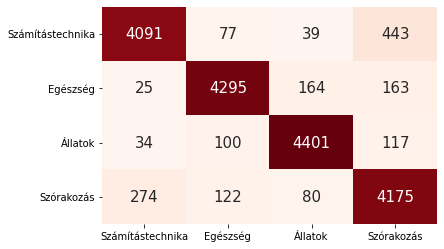

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt

cm = confusion_matrix(test_target[0:len(total_predicted)], total_predicted)
cm_df = pd.DataFrame(cm, index=target_names, columns=target_names)

heatmap = sn.heatmap(cm_df, annot=True, cmap='Reds', fmt='g', annot_kws={"size": 15}, cbar=False)
plt.show()

## Classification report
#### Accuracy
A accuracy érték jelentése: a kérdések mekkora részét sikerült helyesen osztályozni.
#### Precision
A Szórakozás kategóriához tartozó precision érték azt jelenti, hogy az összes Szórakozás kategóriába sorolt kérdés közül mekkora arányban vannak a ténylegesen Szórakozás kategóriájú kérdések.
#### Recall
A recall érték a precision értékhez eléggé hasonló. Az összes ténylegesen Szórakozás kategóriájú kérdés mekkora részét sorolta Szórakozás kategóriába az osztályozó.

In [27]:
from sklearn.metrics import classification_report

class_report = classification_report(test_target[0:len(total_predicted)], total_predicted, target_names=target_names)
print(class_report)

                  precision    recall  f1-score   support

Számítástechnika       0.92      0.88      0.90      4650
        Egészség       0.93      0.92      0.93      4647
         Állatok       0.94      0.95      0.94      4652
      Szórakozás       0.85      0.90      0.87      4651

        accuracy                           0.91     18600
       macro avg       0.91      0.91      0.91     18600
    weighted avg       0.91      0.91      0.91     18600



## Alkategória osztályozás
A főkategória osztályozáshoz hasonló módszerrel próbálkozva. A 4 főkategóriát most elkülönítjük egymástól, 1 tanító adathalamzban csak 1 főkategóriához tartozó kérdések lesznek. Ennek megfelelően az eddig látott dolgokból 4 fog kelleni (háló, tévesztési mátrix, tanító-, tesztelő halmaz stb.)

#### Get target names

In [28]:
target_names_sub = {}
target_dict_sub = {}
num_of_ctg_sub = {}

filtered_df = {}

for t in target_names:
    filtered_df[t] = data_frame[data_frame['kategoriak'].apply(lambda x: x[0]) == t]
    filtered_df[t] = filtered_df[t][filtered_df[t]['kategoriak'].apply(lambda x: x[1]) != 'Egyéb kérdések']
    target_names_sub[t], target_dict_sub[t], num_of_ctg_sub[t] = get_target_names(1, filtered_df[t])


#### Split datasets

In [29]:
train_ratio = 0.8

min_amount_sub = {}

train_each_sub = {}
train_questions_sub = {}
train_size_sub = {}
train_target_sub = {}

test_each_sub = {}
test_questions_sub = {}
test_size_sub = {}
test_target_sub = {}

for t in target_names:
    min_amount_sub[t] = least_questions_in_ctg(1, target_names_sub[t], filtered_df[t])
    
    train_each_sub[t], train_size_sub[t], train_questions_sub[t], train_target_sub[t], \
        test_each_sub[t], test_size_sub[t], test_questions_sub[t], test_target_sub[t] = \
            split_datasets(train_ratio, min_amount_sub[t], 1, filtered_df[t], num_of_ctg_sub[t], target_names_sub[t], target_dict_sub[t])


#### Get vocab

In [30]:
vocab_sub = {}
vocab_size_sub = {}
index_to_word_sub = {}

for t in target_names:
    vocab_sub[t], vocab_size_sub[t], index_to_word_sub[t] = get_vocab(train_questions_sub[t])

In [31]:
learning_rate = 0.005
num_epochs = 2
batch_size = 75

hidden_size = 200

In [32]:
net_sub = {}

for t in target_names:
    print(t)
    net_sub[t] = get_net(vocab_size_sub[t], hidden_size, num_of_ctg_sub[t], learning_rate, num_epochs, train_questions_sub[t], train_target_sub[t], batch_size, index_to_word_sub[t])
    print()

Számítástechnika
Epoch 1/2: 
[49/49] 100.00%
Epoch 2/2: 
[49/49] 100.00%
Egészség
Epoch 1/2: 
[46/46] 100.00%
Epoch 2/2: 
[46/46] 100.00%
Állatok
Epoch 1/2: 
[77/77] 100.00%
Epoch 2/2: 
[77/77] 100.00%
Szórakozás
Epoch 1/2: 
[80/80] 100.00%
Epoch 2/2: 
[80/80] 100.00%


In [33]:
total_pred_sub = {}

for t in target_names:
    print(t)
    total_pred_sub[t] = test_net(net_sub[t], test_questions_sub[t], test_target_sub[t], batch_size, vocab_size_sub[t], index_to_word_sub[t])
    print()

Számítástechnika
Testing... [12/12] 100.00%
Egészség
Testing... [11/11] 100.00%
Állatok
Testing... [19/19] 100.00%
Szórakozás
Testing... [20/20] 100.00%


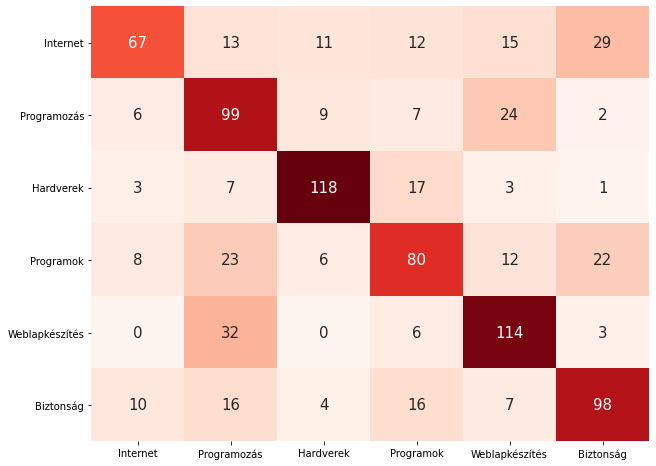

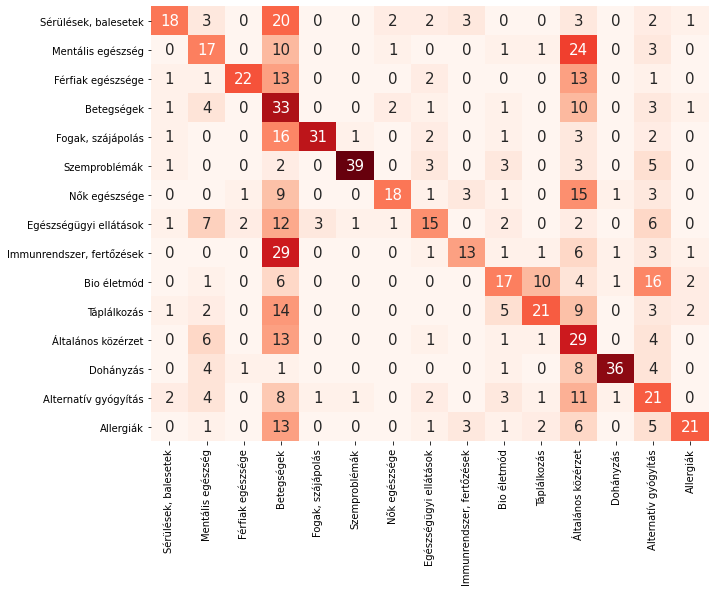

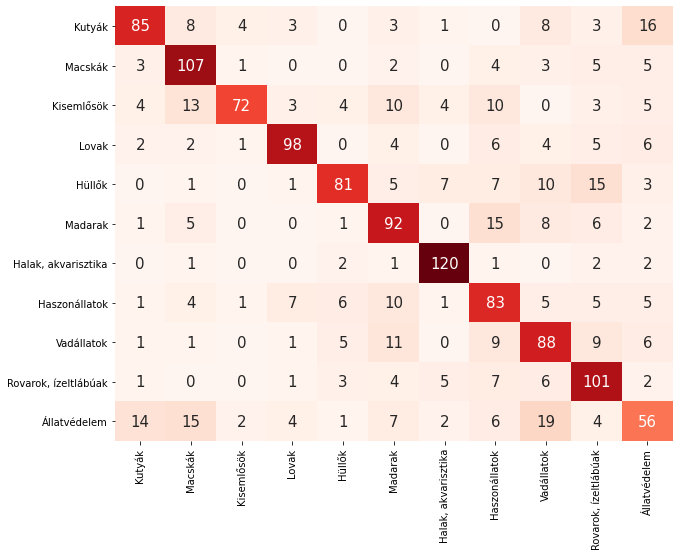

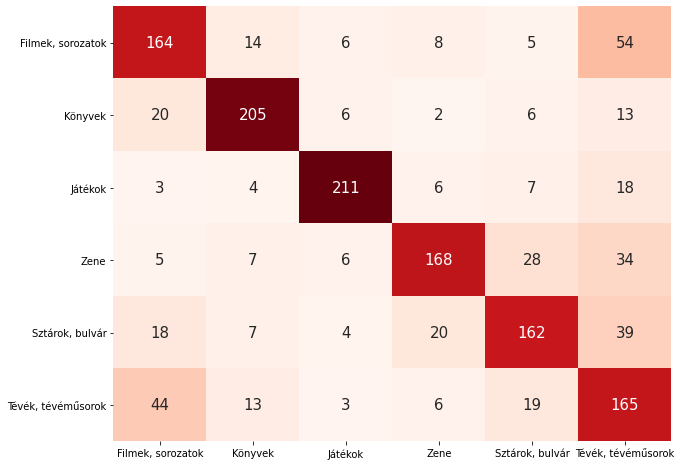

In [34]:
for t in target_names:
    cm = confusion_matrix(test_target_sub[t][0:len(total_pred_sub[t])], total_pred_sub[t])
    cm_df = pd.DataFrame(cm, index=target_names_sub[t], columns=target_names_sub[t])

    plt.figure(figsize = (10,8))
    heatmap = sn.heatmap(cm_df, annot=True, cmap='Reds', fmt='g', annot_kws={"size": 15}, cbar=False)
    plt.show()


In [35]:
for t in target_names:
    class_report = classification_report(test_target_sub[t][0:len(total_pred_sub[t])], total_pred_sub[t], target_names=target_names_sub[t])
    print(class_report)

                precision    recall  f1-score   support

      Internet       0.71      0.46      0.56       147
   Programozás       0.52      0.67      0.59       147
     Hardverek       0.80      0.79      0.79       149
     Programok       0.58      0.53      0.55       151
Weblapkészítés       0.65      0.74      0.69       155
     Biztonság       0.63      0.65      0.64       151

      accuracy                           0.64       900
     macro avg       0.65      0.64      0.64       900
  weighted avg       0.65      0.64      0.64       900

                           precision    recall  f1-score   support

     Sérülések, balesetek       0.69      0.33      0.45        54
        Mentális egészség       0.34      0.30      0.32        57
        Férfiak egészsége       0.85      0.42      0.56        53
               Betegségek       0.17      0.59      0.26        56
        Fogak, szájápolás       0.89      0.54      0.67        57
            Szemproblémák       0.

In [169]:
for idx, val in enumerate(train_questions):
    train_questions[idx] = " ".join(unicode_to_ascii(val))
    
for idx, val in enumerate(test_questions):
    test_questions[idx] = " ".join(unicode_to_ascii(val))

In [170]:
train_df = pd.DataFrame(list(zip(train_target, train_questions)), columns =['Target', 'Question']) 
test_df = pd.DataFrame(list(zip(test_target, test_questions)), columns =['Target', 'Question'])

train_df.to_csv("faq_train.csv", index=False)
test_df.to_csv("faq_test.csv", index = False)

In [171]:
from torchtext import data

Question = data.Field()
Target = data.LabelField(dtype = torch.long)

In [172]:
fields = [('Target',Target),('Question', Question)]

train, test = data.TabularDataset.splits(
                                        path = '.',
                                        train = 'faq_train.csv',
                                        test = 'faq_test.csv',
                                        format = 'csv',
                                        fields = fields,
                                        skip_header = True
)

In [173]:
train, valid = train.split()

In [174]:
print("Training examples: ", len(train))
print("Validation examples: ", len(valid))
print("Testing examples: ", len(test))

Training examples:  52310
Validation examples:  22418
Testing examples:  18680


In [175]:
Question.build_vocab(train, vectors ="glove.6B.100d")  
Target.build_vocab(train)

In [176]:
print(Question.vocab.freqs.most_common(20))

[('a', 172432), ('nem', 60501), ('hogy', 60334), ('es', 57535), ('az', 57047), ('egy', 39610), ('is', 37914), ('de', 32798), ('meg', 30055), ('van', 28628), ('ha', 22288), ('vagy', 19101), ('csak', 17626), ('mar', 16275), ('ez', 16184), ('lehet', 15567), ('volt', 13131), ('nagyon', 12399), ('akkor', 10964), ('mert', 10692)]


In [177]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [178]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits((train, valid, test), batch_size = BATCH_SIZE,
                                                                           sort_key = lambda x: len(x.Question),
                                                                           sort_within_batch = False,
                                                                           device = device)

In [179]:
import torch.nn as nn
from torch import autograd

class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        
        super(LSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.embedding.weight.data.copy_(Question.vocab.vectors)
        self.embedding.weight.requires_grad=False
        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        
        self.fc = nn.Linear(hidden_dim, output_dim)

        
    def forward(self, text):

        #text = [sent len, batch size]
        
        embedded = self.embedding(text)
        
        #embedded = [sent len, batch size, emb dim]
        
        output, hidden = self.lstm(embedded)

        y = self.fc(output[-1])
        
        log_probs = F.log_softmax(y.squeeze(0))
        return log_probs

In [180]:
INPUT_DIM = len(Question.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 100
OUTPUT_DIM = 4

model = LSTMClassifier(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)

In [181]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [182]:
criterion = nn.NLLLoss()

In [183]:
model = model.to(device)
criterion = criterion.to(device)

In [184]:
from sklearn.metrics import classification_report
def class_accuracy(preds, y):
    """
    Returns accuracy per batch
    """
    rounded_preds = preds.argmax(1)
    correct = (rounded_preds == y).float() #convert into float for division 
    #target_names = ['class 0', 'class 1', 'class 2', 'class 3']
    #print(classification_report(rounded_preds.cpu().numpy(), y.cpu().numpy(), target_names=target_names))
    acc = correct.sum() / len(correct)
    return acc

In [185]:
from sklearn.metrics import accuracy_score
import torch.nn.functional as F
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()

        predictions = model(batch.Question)

        loss = criterion(predictions, batch.Target)
        
        acc = class_accuracy(predictions, batch.Target)

        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [186]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.Question)
            
            loss = criterion(predictions, batch.Target)
            
            acc = class_accuracy(predictions, batch.Target)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [187]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [188]:
N_EPOCHS = 15

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

<ipython-input-179-13d909db9b63>:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  log_probs = F.log_softmax(y.squeeze(0))


Epoch: 01 | Epoch Time: 3m 23s
	Train Loss: 1.387 | Train Acc: 25.16%
	 Val. Loss: 1.441 |  Val. Acc: 26.00%
Epoch: 02 | Epoch Time: 3m 34s
	Train Loss: 1.385 | Train Acc: 25.43%
	 Val. Loss: 1.409 |  Val. Acc: 27.48%


In [189]:
model.load_state_dict(torch.load('tut1-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

<ipython-input-179-13d909db9b63>:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  log_probs = F.log_softmax(y.squeeze(0))


Test Loss: 1.406 | Test Acc: 28.04%
